In [2]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

from model import AlexNet

In [ ]:
# data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path(E:\\ml_study,我数据集不是放在该文件夹)
    # 获取当前文件所在的根目录
    data_root = os.getcwd()     # E:\\me_study\\paperwithcode\\AlexNet
    image_path = os.path.join(data_root, "data_set", "flower_data")  # flower data set path(E:\\ml_study\\paperwithcode\\AlexNet\\data_set\\flower_data)
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),    # 加载train数据集,root是train数据集的文件路径
                                         transform=data_transform["train"])         # 使用train数据集对应的transform数据预处理方法
    train_num = len(train_dataset)

    flower_list = train_dataset.class_to_idx    # flower_list: {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
    cla_dict = dict((val, key) for key, val in flower_list.items())     # 将key和val反过来，val作为索引
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)   # 将字典cla_dict转换成json格式
    with open('class_indices.json', 'w') as json_file:  # 将json数据写入文件
        json_file.write(json_str)

    batch_size = 32
    # 下面代码设置nw没看懂
    # nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers（线程数）
    # print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=0)      # windows下最好设置为0，不然可能会出错

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=4, shuffle=True,
                                                  num_workers=0)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    # 简单看下数据集部分内容
    # test_data_iter = iter(validate_loader)
    # test_image, test_label = test_data_iter.next()
    #
    # # 还可以这样，在main方法里定义imshow方法
    # def imshow(img):
    #     img = img / 2 + 0.5  # unnormalize
    #     npimg = img.numpy()
    #     plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #     plt.show()
    #
    # print(' '.join('%5s' % cla_dict[test_label[j].item()] for j in range(4))) # 打印展示的四张图片的label
    # imshow(utils.make_grid(test_image))

    net = AlexNet(num_classes=5, init_weights=True)

    net.to(device)  # 把网络指定到设备上
    loss_function = nn.CrossEntropyLoss()   # 定义损失函数
    # pata = list(net.parameters())         # 查看模型的参数
    optimizer = optim.Adam(net.parameters(), lr=0.0002)     # 定义优化器，优化对象是网络可训练参数，学习率是0.0002

    epochs = 10
    save_path = './AlexNet.pth'     # 保存模型权重的路径
    best_acc = 0.0                  # 定义最佳准确率，初始为0是为了保存准确率最高的模型
    train_steps = len(train_loader)
    for epoch in range(epochs):     # 迭代10次
        # train
        net.train()                 # 在训练过程中调用net.train()方法就会启用dropout方法
        running_loss = 0.0          # 统计在训练过程中的平均损失
        train_bar = tqdm(train_loader, file=sys.stdout)     # 这句代码是显示进度
        # 遍历数据集
        for step, data in enumerate(train_bar):
            images, labels = data   # 将数据分为图像和标签
            optimizer.zero_grad()   # 清空梯度
            outputs = net(images.to(device))    # 先将图片指定到设备上，这里没有gpu，所以指定到cpu上处理，然后再传入模型
            loss = loss_function(outputs, labels.to(device))    # 计算预测值和真实值的损失
            loss.backward()     # 反向传播到每个节点上
            optimizer.step()    # 使用优化器更新节点参数

            # print statistics(打印数据)
            running_loss += loss.item()     # 将loss累加到running_loss

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)

        # validate
        net.eval()                  # 在验证过程中调用net.eval()方法就会停用dropout方法（验证过程不需要dropout）
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():       # 验证过程中禁止计算梯度
            val_bar = tqdm(validate_loader, file=sys.stdout)    # 同样使用tqdm包来打印进度
            for val_data in val_bar:
                val_images, val_labels = val_data               # 将数据划分为图片和标签
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]        # 将输出结果outputs中最大值对应的那个类别作为预测值
                # 将预测值与真实值进行对比，sum是统计预测正确的个数，item是将得到结果转换成数值类型
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = acc / val_num    # 测试集的准确率
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:     # 如果当前准确率大于最优准确率，则更新最优准确率
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)     # 保存当前的模型权重信息

    print('Finished Training')

In [ ]:
if __name__ == '__main__':
    main()

运行结果

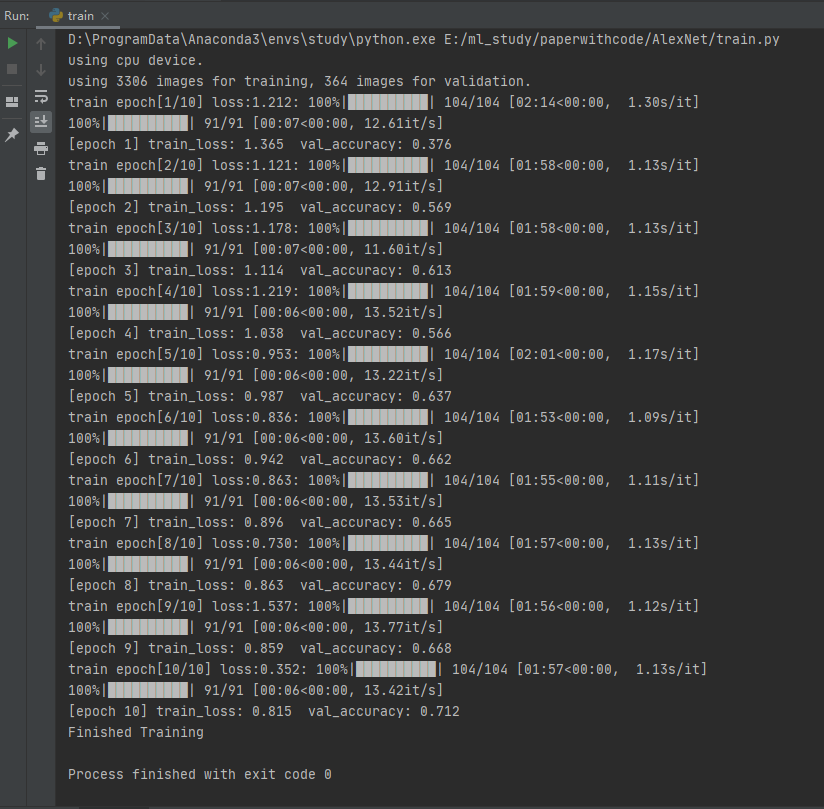

上图的输出结果可以分成10部分，每个部分都是由3小条构成：

1. train epoch[1/10] loss:1.212: 100%|██████████| 104/104 [02:14<00:00,  1.30s/it]
2. 100%|██████████| 91/91 [00:07<00:00, 12.61it/s]
3. [epoch 1] train_loss: 1.365  val_accuracy: 0.376

其中1对应的代码是

train_bar = tqdm(train_loader, file=sys.stdout)     # 这句代码是显示进度，和

train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)

其中3对应的代码是

print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' % (epoch + 1, running_loss / train_steps, val_accurate))